# Time evolution for N>3 spins
-----------------------------------------------------------

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from qiskit import *

In [14]:
from qiskit.circuit import Parameter

N = 8 # number of spins; scale up *slowly*, as computational load increases exponentially with N
Nhalf = int(0.5*N)
J = 1.0
Jz = 10.0

t = Parameter('t')
Nt = 20 #number of time samples
tmax = float(Nhalf)
tau_range = np.linspace(0,tmax,Nt)

ntrot = 100 #Trotter steps

qr = QuantumRegister(N,'q')
cr = ClassicalRegister(N,'c')

timecirc = QuantumCircuit(qr,cr)

In [15]:
Ngate_qr = QuantumRegister(2)
Ngate_qc = QuantumCircuit(Ngate_qr,name='N3')

Ngate_qc.rz(-0.5*np.pi,Ngate_qr[1])
Ngate_qc.cx(Ngate_qr[1],Ngate_qr[0])
Ngate_qc.rz(0.5*np.pi-2*Jz*t/(4.0*ntrot),Ngate_qr[0])
Ngate_qc.ry(2.0*J*t/(4.0*ntrot)-0.5*np.pi,Ngate_qr[1])
Ngate_qc.cx(Ngate_qr[0],Ngate_qr[1])
Ngate_qc.ry(0.5*np.pi-2.0*J*t/(4.0*ntrot),Ngate_qr[1])
Ngate_qc.cx(Ngate_qr[1],Ngate_qr[0])
Ngate_qc.rz(0.5*np.pi,Ngate_qr[0])

N_gate = Ngate_qc.to_instruction()

In [16]:
#domain wall initial state |ψ> = |++...++--...-->
timecirc.x(qr[0:Nhalf])

for _ in range(0,ntrot):
    for i in range(0,N-1):
        timecirc.append(N_gate, [qr[i], qr[i+1]])

timecirc.measure(qr,cr)

In [17]:
from qiskit.primitives import StatevectorSampler

sampler = StatevectorSampler()

nshots = 8192

pub = (timecirc, tau_range)

job = sampler.run([pub], shots=nshots)
result = job.result()[0]

In [18]:
Szt = np.zeros((N,Nt))

for i in range(0,Nt):
    simcounts = result.data.c.get_counts(i)
    keylist = list(simcounts.keys())
    for j in range(0,len(keylist)):
        state = keylist[j]
        
        for k in range(0,N):
            if (state[k]=='0'):
                Szt[k,i] = Szt[k,i] + simcounts[state]
            else:
                Szt[k,i] = Szt[k,i] - simcounts[state]
        
Szt = 0.5*Szt/nshots    

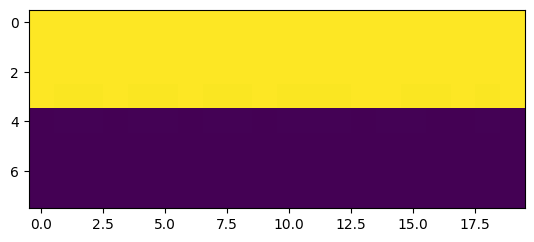

In [13]:
plt.imshow(Szt)
plt.show()

## Equivalent execution using ```Estimator``` (more computationally efficient)

In [11]:
N = 12 # number of spins; scale up *slowly*, as computational load increases exponentially with N
Nhalf = int(0.5*N)
J = 1.0
Jz = 0.10

t = Parameter('t')
Nt = 20 #number of time samples
tmax = float(Nhalf)
tau_range = np.linspace(0,tmax,Nt)

ntrot = 100 #Trotter steps

qr = QuantumRegister(N,'q')
cr = ClassicalRegister(N,'c')

timecirc = QuantumCircuit(qr,cr)

#domain wall initial state |ψ> = |++...++--...-->
timecirc.x(qr[0:Nhalf])

for _ in range(0,ntrot):
    for i in range(0,N-1):
        timecirc.append(N_gate, [qr[i], qr[i+1]])

In [12]:
from qiskit.quantum_info import SparsePauliOp

pad = "I"
for j in range(0,N-2):
    pad = pad + "I"
    
Sop = [[SparsePauliOp.from_list([("Z"+pad, 0.5)])]]

for i in range(0,N):
    if (i==N-1):
        pad = "I"
        for j in range(0,N-2):
            pad = pad + "I"
            
        Sop.append([SparsePauliOp.from_list([(pad+"Z", 0.5)])])
    
    else:
        if (i!=0):
            l = "I"
            for j in range(0,i-1):
                l = l + "I"
    
            r = "I"
            for j in range(0,N-i-2):
                r = r + "I"
            
            Sop.append([SparsePauliOp.from_list([(l + "Z" + r, 0.5)])])
                


In [13]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()

pub = (
    timecirc,  # circuit
    Sop,  # Observables
    tau_range,
)

job_result = estimator.run(pubs=[pub]).result()

In [14]:
Szt = np.zeros((N,Nt))

for i in range(0,N):
    Szt[i,:] = job_result[0].data.evs[i]

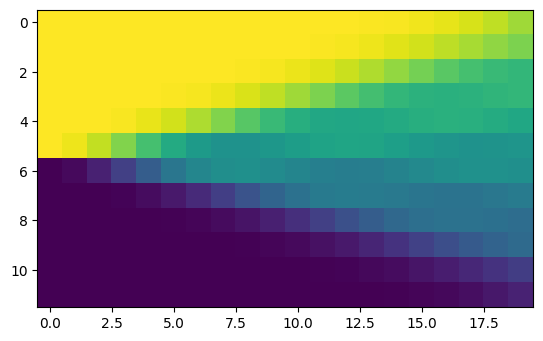

In [15]:
plt.imshow(Szt)
plt.show()

## Version information:

In [18]:
import qiskit 

qiskit.version.get_version_info()

'1.1.1'